# Impact assessment of invasive plant species distribution on special interest areas
Rank special interest areas based on the potential impact of invasive plant species spread.
Input data:
- GeoTiff with species distribution map
- Geopackage with special interest areas

In [5]:
import geopandas as gpd
import sklearn.cluster as skc
import numpy as np 

In [1]:
aoi_path = "N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f06_POIs/AOIs_OSM_2169.gpkg"

<Axes: >

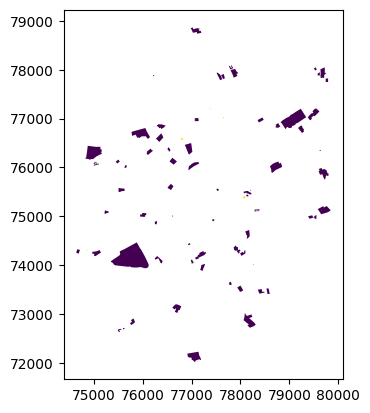

In [66]:
gdf = gpd.read_file(aoi_path)
gdf = gdf.to_crs("EPSG:2169")

# select only schools (2) and kindergartens (3)
gdf = gdf[gdf['aoi_name'].isin([2,3])]
gdf.plot('aoi_name')

## Cluster nearby features
### Get centroids 

In [67]:
gdf['point'] = gdf.centroid

### Clustering with DBSCAN
Since we're interested in the locations and sklearn isn't conversant in geodataframes, we'll need to get the point array from the geodataframe:

In [ ]:
coordinates = gdf['point'].apply(lambda p: np.hstack(p.xy)).values # type: ignore
coordinates = np.vstack(coordinates)

In [69]:
clusterer = skc.DBSCAN(eps=300, min_samples=2).fit(coordinates)

To map the clusters, we need to assign them back to the dataframe and plot them:

In [70]:
gdf = gdf.assign(labels=clusterer.labels_)

In [71]:
gdf.explore(
    column="labels",  # make choropleth based on "BoroName" column
    tooltip="labels",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles
    cmap="Set1",  # use "Set1" matplotlib colormap
    # style_kwds=dict(color="black"),  # use black outline
)

In [72]:
# assign different indices to features with label -1
gdf.loc[gdf['labels'] == -1, 'labels'] = -gdf.loc[gdf['labels'] == -1].index


In [93]:
# dissolve features based on labels
gdf_new = gdf.dissolve(by='labels')
gdf_new['buffer'] = gdf_new.buffer(100)
gdf_new['buffer'].explore()

In [76]:
gdf_new.reset_index(drop=True, inplace=True)

In [94]:
#save vector to file
gdf_new[['buffer', 'amenity','aoi_name']].to_file("N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f06_POIs/AOIs_school_kind_100m_buffer_v2.gpkg", driver="GPKG")

## Compute zonal statistics

In [17]:
# compute zonal statistics
import rasterstats as rs
raster_path = "N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f05_distribution/f03_distribution_maxent/20250226160140_fallopia_japonica_maxent_2169.tif"
vector_path = "N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f04_vector_collection/f06_POIs/AOIs_school_kind_100m_buffer.gpkg"

In [18]:
zonal_stats_result = rs.zonal_stats(vector_path, raster_path,
            stats="count min mean max median", all_touched=True, geojson_out=True, prefix="")

In [ ]:
gdf_stats = gpd.GeoDataFrame.from_features(zonal_stats_result)
gdf_stats.crs = "EPSG:2169"
gdf_stats.to_file("N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f05_distribution/f03_distribution_maxent/zonal_statistics/20250226160140_fallopia_japonica_maxent_AOIs_school_kind_100m_buffer_stats.gpkg", driver="GPKG")

## Compare zonal statistics across species

In [1]:
import glob
import pandas as pd
import geopandas as gpd

In [2]:
# read location names from csv
location_names = pd.read_csv("N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f04_vector_collection/AOIs/school_names_v2.csv")

In [ ]:
zonal_stats = "N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f05_distribution/f03_distribution_maxent/zonal_statistics/*_AOIs_school_kind_100m_buffer_stats.gpkg"
zonal_stats_files = glob.glob(zonal_stats)
zonal_stats_names = [f.split("\\")[-1].split("_")[1] for f in zonal_stats_files]
# open and merge all zonal statistics files (ignore spatial dimension)
df_list = [gpd.read_file(f) for f in zonal_stats_files]
df = df_list[0][["labels", "amenity", "mean", "count"]].rename(columns={"mean": zonal_stats_names[0]+"_mean"})
for tmp, n in zip(df_list[1:], zonal_stats_names[1:]):
    df = pd.merge(df, tmp[['labels', 'mean']].rename(columns={"mean": n+"_mean"}))
df = pd.merge(df, location_names, on="labels")

In [18]:
schools_buffer = pd.merge(df_list[0], location_names, on="labels")
schools_buffer.drop(columns=['labels', 'amenity_x', 'aoi_name', 'min', 'max', 'mean', 'count',
       'median', 'amenity_y', 'location_name'], inplace=True)

In [19]:
schools_buffer.rename(columns={'location_name_cleaned': 'schoolname'}, inplace=True)

In [20]:
# add index as column
schools_buffer['index'] = schools_buffer.index
schools_buffer[['index', 'schoolname', 'district', 'geometry']].to_file("N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f04_vector_collection/AOIs/luxembourg_city_schools.shp")

In [5]:
# compute average of all mean values
df['mean'] = df[[c for c in df.columns if c.endswith("_mean")]].mean(axis=1)
df.sort_values(by="mean", ascending=False, inplace=True)

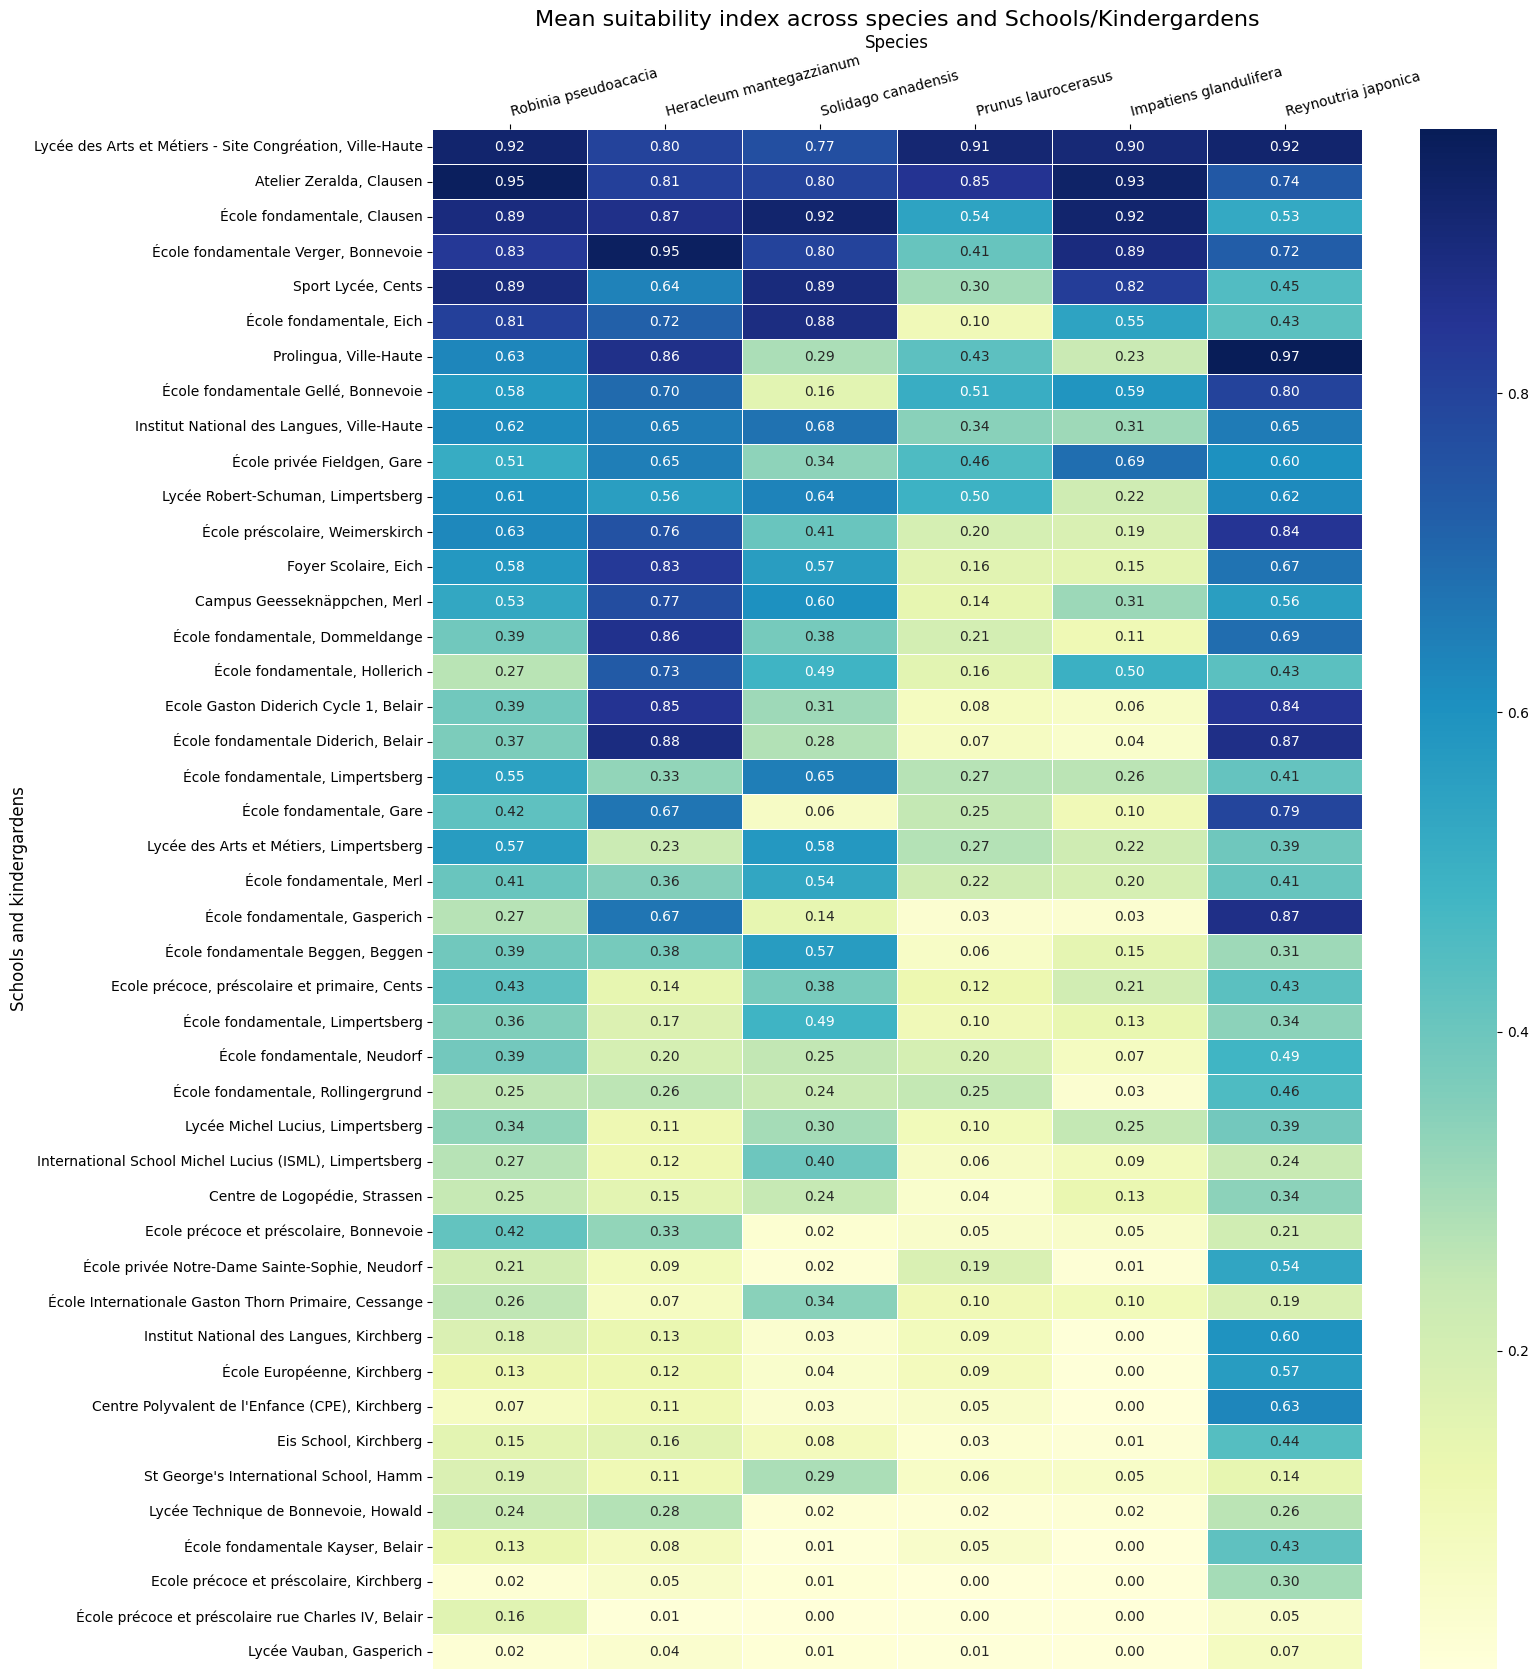

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
# Extract just the mean values for the heatmap
mean_columns = [col for col in df.columns if col.endswith('_mean')]
heatmap_data = df[['location_name_cleaned'] + mean_columns].set_index('location_name_cleaned')

# Rename columns to remove the "_mean" suffix for cleaner visualization
# heatmap_data.columns = [col.replace('_mean', '').replace('_', ' ').capitalize() for col in heatmap_data.columns]
heatmap_data.columns = ['Robinia pseudoacacia', 
                        'Heracleum mantegazzianum',
                        'Solidago canadensis', 
                        'Prunus laurocerasus', 
                        'Impatiens glandulifera',
                        'Reynoutria japonica']
# Create the heatmap
plt.figure(figsize=(15, 20))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Mean suitability index across species and Schools/Kindergardens', fontsize=16)
plt.ylabel('Schools and kindergardens', fontsize=12)
plt.xlabel('Species', fontsize=12)
# show xlabel on top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
# show xlabel with 45 degree rotation
plt.xticks(rotation=15, ha='left')
# save the plot
plt.savefig("N:/C2205_FAIRiCUBE/f07_images/VdL_neophytes/schools_zonal_stats_all.png.png", dpi=300)
# plt.tight_layout()
plt.show()


In [12]:
heatmap_data.columns

Index(['Robinia', 'Fallopia', 'Impatiens', 'Heracleum', 'Solidago', 'Prunus'], dtype='object')

In [2]:
import xarray
ds =  xarray.DataArray()
ds.to_zarr("N:/C2205_FAIRiCUBE/f07_images/VdL_neophytes/schools_zonal_stats_all.zarr")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject